In [539]:
import pandas as pd

In [540]:
df = pd.read_csv('transaction_anomalies_dataset.csv')
df.head()

,Transaction_ID,Transaction_Amount,Transaction_Volume,Average_Transaction_Amount,Frequency_of_Transactions,Time_Since_Last_Transaction,Day_of_Week,Time_of_Day,Age,Gender,Income,Account_Type
0,TX0,1024.835708,3,997.234714,12,29,Friday,06:00,36,Male,1436074,Savings
1,TX1,1013.952065,4,1020.210306,7,22,Friday,01:00,41,Female,627069,Savings
2,TX2,970.956093,1,989.496604,5,12,Tuesday,21:00,61,Male,786232,Savings
3,TX3,1040.822254,2,969.522480,16,28,Sunday,14:00,61,Male,619030,Savings
4,TX4,998.777241,1,1007.111026,7,7,Friday,08:00,56,Female,649457,Savings


### No nulls within our data set. That gives us the go ahead!

In [541]:
df.isnull().sum()

Transaction_ID                 0
Transaction_Amount             0
Transaction_Volume             0
Average_Transaction_Amount     0
Frequency_of_Transactions      0
Time_Since_Last_Transaction    0
Day_of_Week                    0
Time_of_Day                    0
Age                            0
Gender                         0
Income                         0
Account_Type                   0
dtype: int64

## Data EDA and data profiling

In [542]:
df.describe()

,Transaction_Amount,Transaction_Volume,Average_Transaction_Amount,Frequency_of_Transactions,Time_Since_Last_Transaction,Age,Income
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,1038.122511,2.498000,1000.682506,12.078000,15.341000,40.641000,8.948238e+05
std,283.580055,1.115006,20.632334,4.245225,8.361258,13.819953,3.453562e+05
min,849.024392,1.000000,939.081423,5.000000,1.000000,18.000000,3.001590e+05
25%,966.028796,1.000000,986.800556,8.000000,8.000000,29.000000,5.917308e+05
50%,1002.118678,3.000000,1000.501902,12.000000,16.000000,41.000000,8.876645e+05
75%,1033.143657,3.000000,1015.155595,16.000000,22.000000,53.000000,1.178102e+06
max,3227.459108,4.000000,1073.154036,19.000000,29.000000,64.000000,1.499670e+06


## Data distribution within our main 'Transaction_Amount' columns

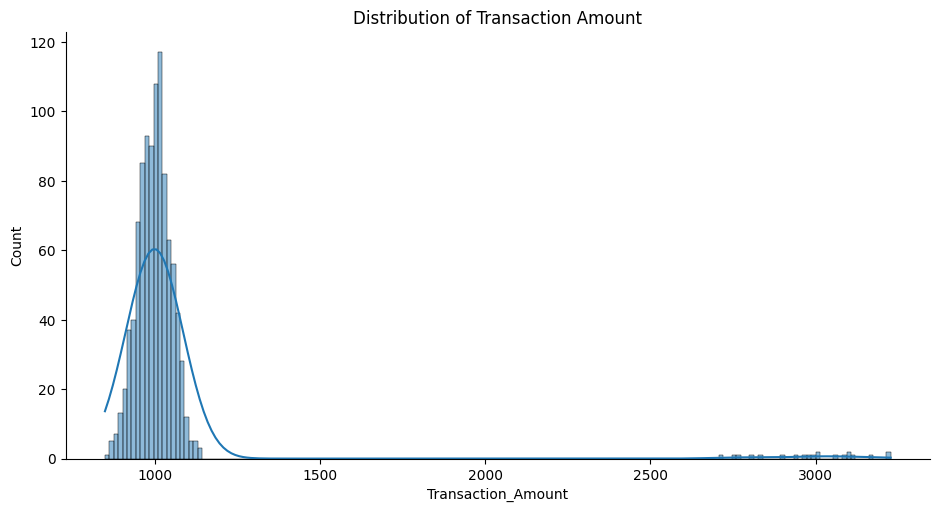

In [545]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.displot(x=df['Transaction_Amount'],kde=True, height=5, aspect=1.9)
plt.title('Distribution of Transaction Amount')
plt.show()

## Data distribution of transaction amount with respect to account type

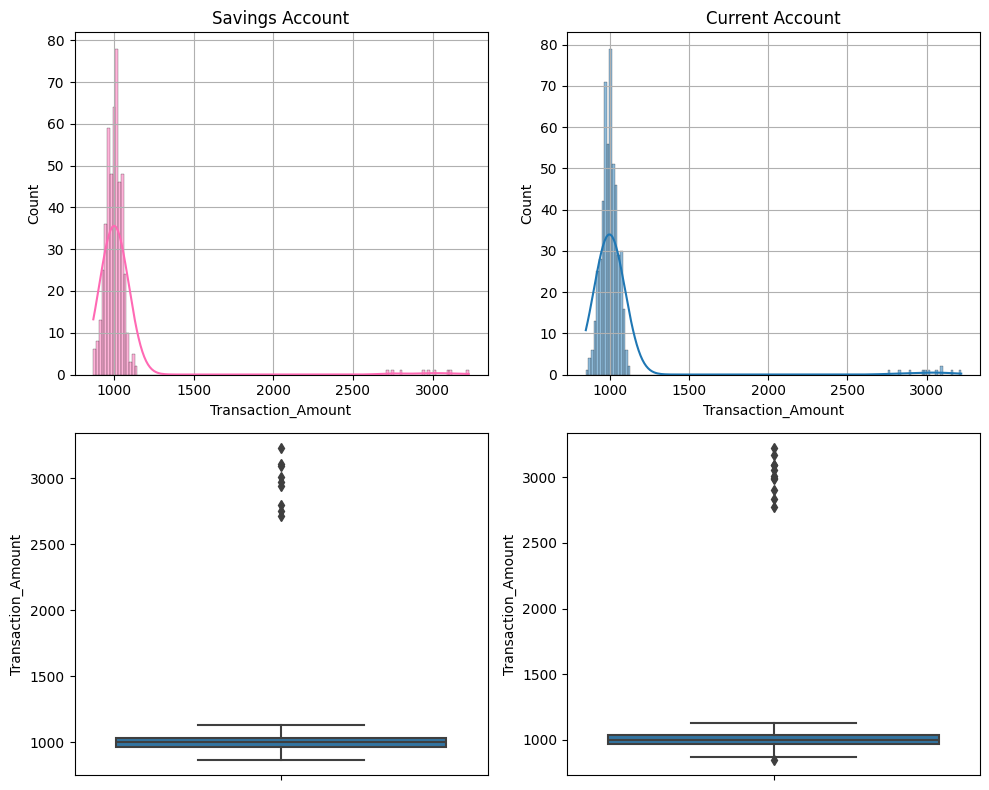

In [544]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot distribution plots on each subplot
sns.histplot(data=df[df['Account_Type']=='Savings'], x='Transaction_Amount', kde=True, ax=axes[0,0], color='hotpink')
sns.histplot(data=df[df['Account_Type']=='Current'], x='Transaction_Amount', kde=True, ax=axes[0,1])
sns.boxplot(data=df[df['Account_Type']=='Savings'], y='Transaction_Amount', ax=axes[1,0])
sns.boxplot(data=df[df['Account_Type']=='Current'], y='Transaction_Amount', ax=axes[1,1])

# Add titles
axes[0,0].set_title('Savings Account')
axes[0,1].set_title('Current Account')
axes[0,0].grid()
axes[0,1].grid()

# Show plot
plt.tight_layout()
plt.show()

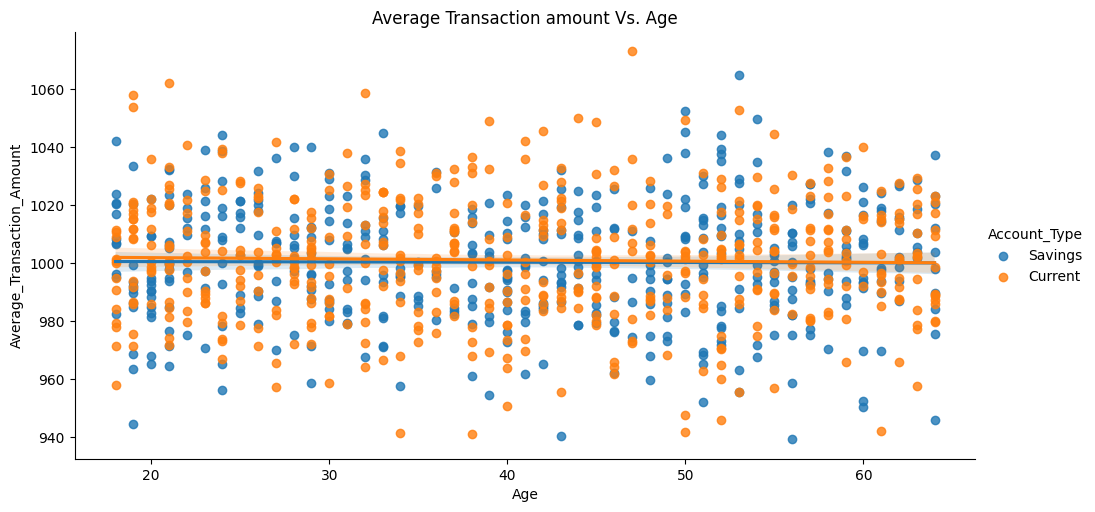

In [556]:
sns.lmplot(data=df, x='Age', y='Average_Transaction_Amount', hue='Account_Type', aspect=2)
plt.title('Average Transaction amount Vs. Age')
plt.show()

## Average transaction amounts by age across different account types

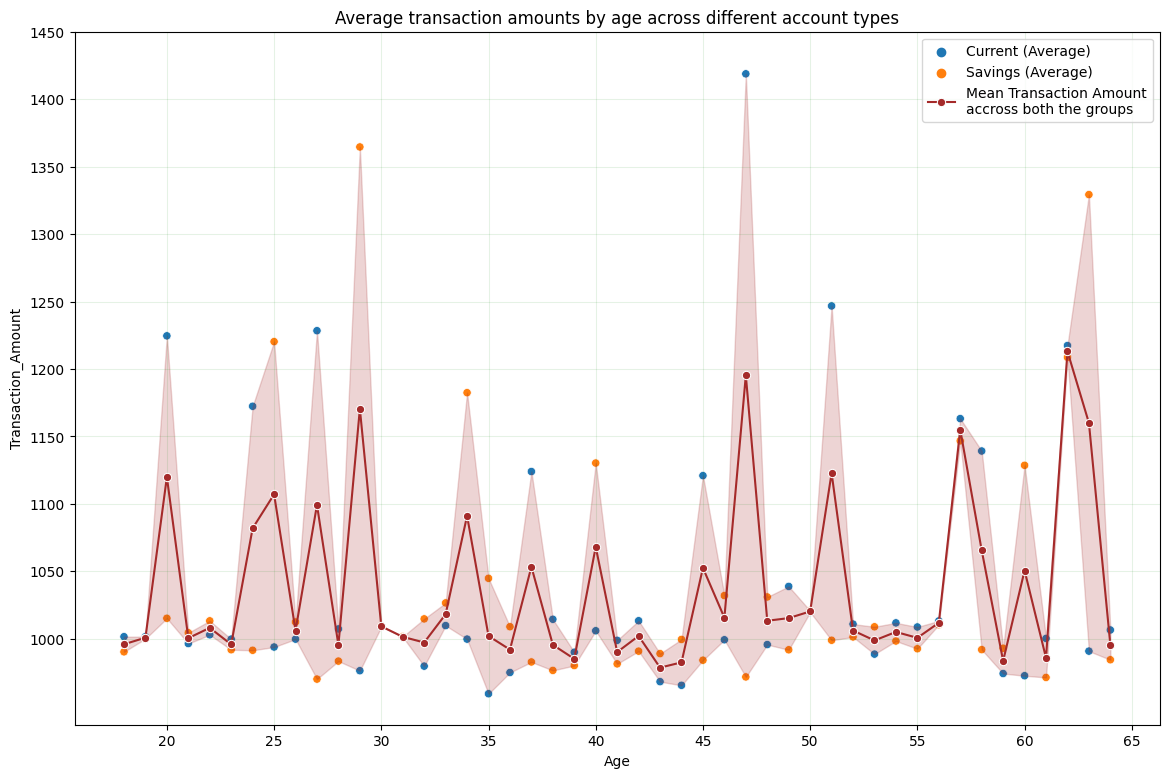

In [558]:
plt.figure(figsize=(14,9))

data = df.groupby(['Account_Type','Age']).agg({'Transaction_Amount':'mean'}).reset_index()

sns.scatterplot(data=data, x='Age', y='Transaction_Amount', hue='Account_Type')
sns.lineplot(data=data ,x='Age', y='Transaction_Amount',  marker='o', color='brown', label='Mean Transaction Amount\naccross both the groups')
plt.grid(color='green', alpha=0.1)
plt.yticks(range(1000,1500, 50))
plt.xticks(range(20,70, 5))
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Current (Average)','Savings (Average)','Mean Transaction Amount\naccross both the groups'])
plt.title('Average transaction amounts by age across different account types')
plt.show()

## Weekday Transaction counts

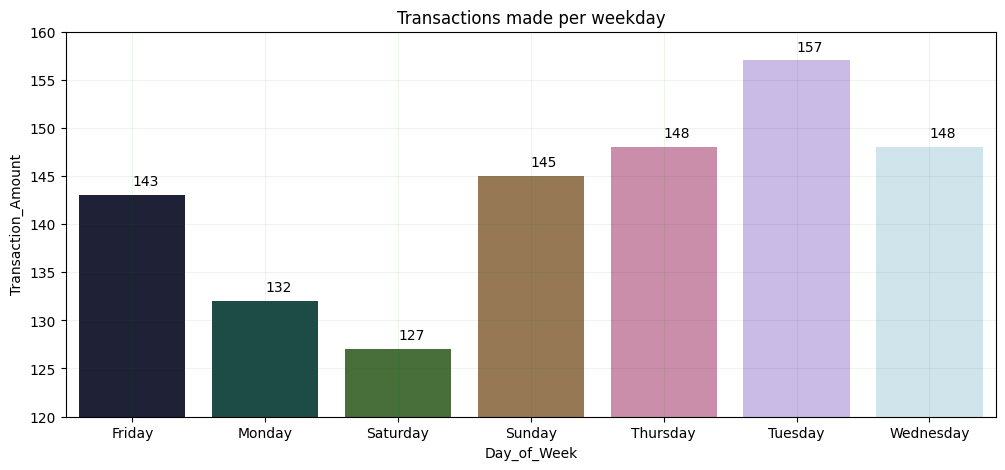

In [565]:
df.head()
bars = plt.figure(figsize=(12,5))
data = df.groupby(['Day_of_Week']).agg({'Transaction_Amount':'count'}).reset_index()
sns.barplot(data=data, x='Day_of_Week',y='Transaction_Amount', palette='cubehelix')
plt.ylim(120,160)

xticks = plt.xticks()[1]
for i in range(len(xticks)):
    plt.annotate(data.iloc[i,1], (i,data.iloc[i,1]+1))
plt.grid(color='green', alpha=0.08)
plt.title('Transactions made per weekday')

plt.show()

## Features correlation

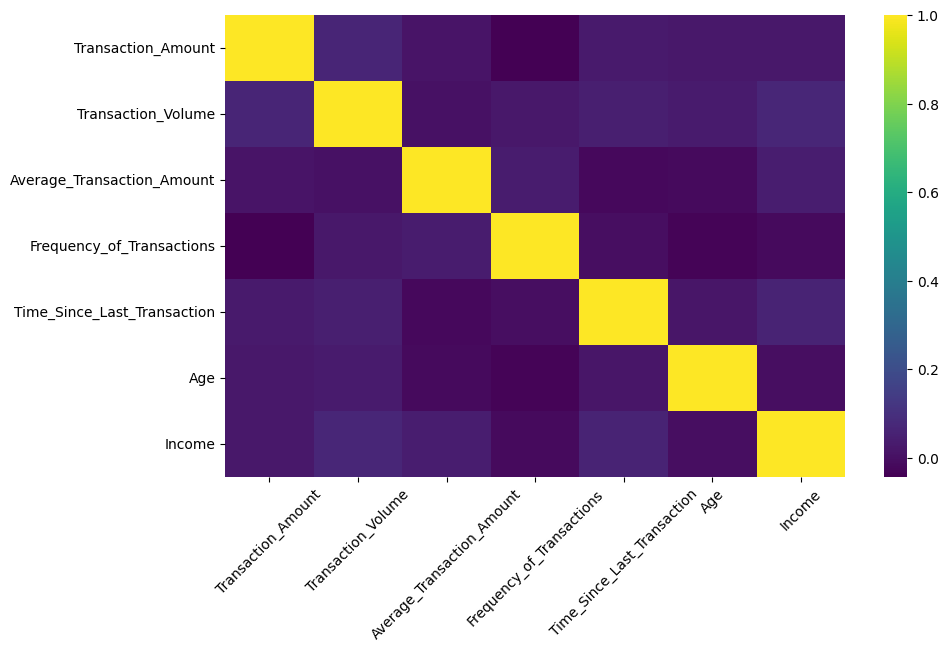

In [172]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes([int,float]).corr(), cmap='viridis')
plt.xticks(rotation=45)
plt.show()


### One of the disadvantages of Isolation Forest is that it asks for a probable value of contamination before hand Ie It asks for the percentage of data that may be contaminated or anomalous. To figure out this contamination value, one has to have good domain knowledge. In our dataset, we rest our case on the outlier analysis done  below which can later tell us a good deal about contamination percentage.

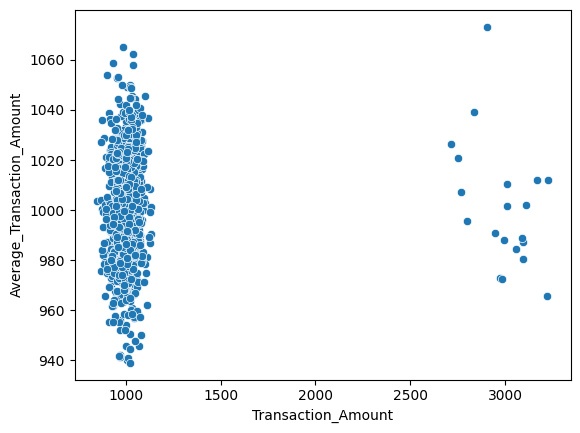

In [421]:
sns.scatterplot(data=df, x='Transaction_Amount', y='Average_Transaction_Amount')
plt.show()

## Finding outliers to come up with a number for contamination percentage

In [568]:
Q1 = df['Transaction_Amount'].quantile(0.25)
Q3 = df['Transaction_Amount'].quantile(0.75)
IQR = Q3-Q1

lower_bound = Q1 - 1.3 * IQR
upper_bound = Q3 + 1.3 * IQR

print(f'Lower bound for normal transactions: {round(lower_bound)}')
print(f'Upper bound for normal transactions: {round(upper_bound)}')

Lower bound for normal transactions: 879
Upper bound for normal transactions: 1120


### Plotting in the outliers detected

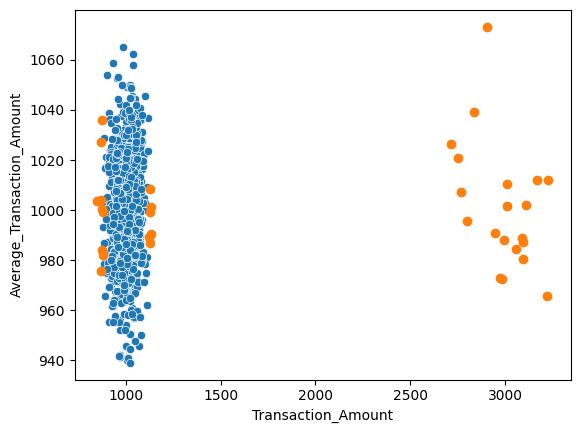

In [527]:
# With the line below, we get the indices of all the cases that have been marked as outliers
outliers = df[(df['Transaction_Amount']>upper_bound) | (df['Transaction_Amount']<lower_bound)].index

# With the lines below, we create a simple scatter plot with seaborn. The apply another scatter plot on top of it
# to show the outlier points
sns.scatterplot(data=df,x='Transaction_Amount', y='Average_Transaction_Amount')
plt.scatter(df.iloc[outliers]['Transaction_Amount'], df.iloc[outliers]['Average_Transaction_Amount'])
plt.show()


### Creating a new 'is_anomaly' feature

In [569]:

# We create another feature 'is_anomaly' with values [1:anomaly] and [2:normal]
df['is_anomaly'] = ((df['Transaction_Amount']>upper_bound) | (df['Transaction_Amount']<lower_bound)).astype(int)
df.head()

,Transaction_ID,Transaction_Amount,Transaction_Volume,Average_Transaction_Amount,Frequency_of_Transactions,Time_Since_Last_Transaction,Day_of_Week,Time_of_Day,Age,Gender,Income,Account_Type,is_anomaly
0,TX0,1024.835708,3,997.234714,12,29,Friday,06:00,36,Male,1436074,Savings,0
1,TX1,1013.952065,4,1020.210306,7,22,Friday,01:00,41,Female,627069,Savings,0
2,TX2,970.956093,1,989.496604,5,12,Tuesday,21:00,61,Male,786232,Savings,0
3,TX3,1040.822254,2,969.522480,16,28,Sunday,14:00,61,Male,619030,Savings,0
4,TX4,998.777241,1,1007.111026,7,7,Friday,08:00,56,Female,649457,Savings,0


In [570]:
# Applying value_counts to see number of total number of normal and anomalous instances
df['is_anomaly'].value_counts()

is_anomaly
0    965
1     35
Name: count, dtype: int64

## Now we calculate the ratio between anomaly to normal cases, to give us an idea of how much 'contaminated' out data is. This contamination ratio is later to be used in Isolation Forest algorithm

In [571]:

v = df['is_anomaly'].value_counts().values
contamination_ratio = v[1]/v[0]
print(f'"Anomaly" to "Normal" ratio: {contamination_ratio}')


"Anomaly" to "Normal" ratio: 0.03626943005181347


### We train our Isolation Forest algorithm on our data with our calculated contamination ratio

In [622]:
y = df['is_anomaly']
xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)
ytrain = ytrain.map({0:1, 1:-1})
ytest = ytest.map({0:1, 1:-1})

In [628]:
import numpy as np
from sklearn.ensemble import IsolationForest

# Selecting only these three features
X = df.select_dtypes([int,float])[['Transaction_Amount', 'Average_Transaction_Amount', 'Frequency_of_Transactions']]#, 'Time_Since_Last_Transaction', 'Age', 'Income']]
model = IsolationForest(contamination=contamination_ratio, random_state=42)

model.fit(xtrain, ytrain)
pred = model.predict(X)

# The line below calculates scores for each instance. The lower the score, the closer it is to being an anomaly
df['scores'] = model.decision_function(X)

#Taking out indices of the anomalies
yind = np.where(pred == -1)[0]
yind

array([ 20,  27,  59,  60, 147, 151, 188, 230, 246, 252, 285, 307, 373,
       400, 422, 426, 474, 484, 550, 570, 575, 586, 589, 669, 703, 715,
       724, 762, 772, 785, 807, 815, 825, 855, 869, 878, 920, 936, 991])

### Now plotting the results

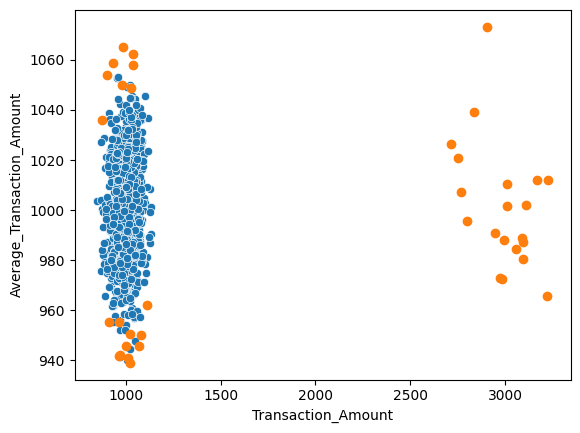

In [629]:
sns.scatterplot(data=df, x='Transaction_Amount' , y='Average_Transaction_Amount')
plt.scatter(df.iloc[yind]['Transaction_Amount'], df.iloc[yind]['Average_Transaction_Amount'])
plt.show()

## Classification report on validation data

In [630]:
from sklearn.metrics import classification_report, accuracy_score

y_pred=model.predict(xtest)
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

          -1       0.50      0.71      0.59         7
           1       0.99      0.97      0.98       193

    accuracy                           0.96       200
   macro avg       0.74      0.84      0.78       200
weighted avg       0.97      0.96      0.97       200



In [619]:
accuracy_score(ytest, y_pred)

0.965

In [634]:
a =float(input('Enter the value for "Transaction Amount": '))
b =float(input('Enter the value for "Average_Transaction_Amount": '))
c =float(input('Enter the value for "Frequency_of_Transaction": '))

res = model.predict([[a,b,c]])[0]

if res==-1:
    print('Anomaly Detected: This transaction is flagged as anomalous')
    

Enter the value for "Transaction Amount": 10000
Enter the value for "Average_Transaction_Amount": 900
Enter the value for "Frequency_of_Transaction": 6
Anomaly Detected: This transaction is flagged as anomalous
